In [1]:
#IMPORTAÇÃO DE BIBLIOTECAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Bibliotecas para processamento de dados
from scipy.io import arff
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

In [3]:
#Bibliotecas para machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [4]:
#Métricas de avaliação
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, precision_recall_curve,
                             f1_score, accuracy_score, precision_score,
                             recall_score, average_precision_score)

In [5]:
#Para salvar o modelo
import joblib
import json
import pickle

In [6]:
#Configurações de visualização
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print("Bibliotecas importadas com sucesso!")

Bibliotecas importadas com sucesso!


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
# Configurar caminho do dataset
path_dataset = "/content/drive/MyDrive/dataset_.arff"

In [9]:
# Converter para DataFrame
data, meta = arff.loadarff(path_dataset)
df = pd.DataFrame(data)

# Converter colunas em bytes para string (problema comum com .arff)
df = df.applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)

# Converter coluna 'Class' para numérica
df['Class'] = df['Class'].astype(int)

print(f"Dataset carregado: {df.shape[0]} linhas × {df.shape[1]} colunas")

Dataset carregado: 284807 linhas × 31 colunas



3. ANÁLISE EXPLORATÓRIA DOS DADOS (EDA)

 VISÃO GERAL DO DATASET:
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 n

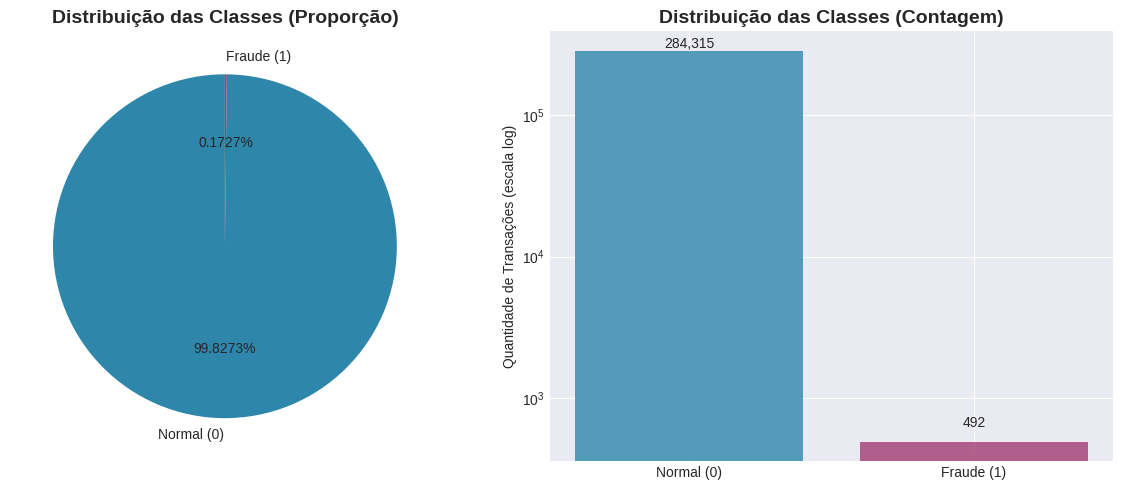

In [10]:
#ANÁLISE EXPLORATÓRIA COMPLETA (EDA)

print("\n" + "="*80)
print("3. ANÁLISE EXPLORATÓRIA DOS DADOS (EDA)")
print("="*80)

#Visão geral do dataset
print("\n VISÃO GERAL DO DATASET:")
print("-" * 40)
print(df.info())
print("\n ESTATÍSTICAS DESCRITIVAS:")
print(df.describe())

#Análise da distribuição das classes
print("\n ANÁLISE DA VARIÁVEL TARGET (Class):")
print("-" * 40)
class_distribution = df['Class'].value_counts()
class_percentage = df['Class'].value_counts(normalize=True) * 100

print(f"Transações Normais (Class=0): {class_distribution[0]:,} ({class_percentage[0]:.4f}%)")
print(f"Transações Fraudulentas (Class=1): {class_distribution[1]:,} ({class_percentage[1]:.4f}%)")
print(f"Taxa de desbalanceamento: {class_distribution[0]/class_distribution[1]:.1f}:1")

#Visualização da distribuição das classes
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
colors = ['#2E86AB', '#A23B72']
plt.pie(class_distribution.values, labels=['Normal (0)', 'Fraude (1)'],
        colors=colors, autopct='%1.4f%%', startangle=90)
plt.title('Distribuição das Classes (Proporção)', fontsize=14, fontweight='bold')

plt.subplot(1, 2, 2)
bars = plt.bar(['Normal (0)', 'Fraude (1)'], class_distribution.values,
               color=colors, alpha=0.8)
plt.title('Distribuição das Classes (Contagem)', fontsize=14, fontweight='bold')
plt.ylabel('Quantidade de Transações (escala log)', fontsize=10)
plt.yscale('log')

# Adicionar valores nas barras
for bar, value in zip(bars, class_distribution.values):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 100,
             f'{value:,}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


 ANÁLISE COMPARATIVA: NORMAL vs FRAUDE
----------------------------------------
         Contagem  Valor Médio (Amount)  Valor Médio (Time)  \
Normal 284315.000                88.291           94838.202   
Fraude    492.000               122.211           80746.807   

        Desvio Padrão (Amount)  
Normal                 250.105  
Fraude                 256.683  

 ANÁLISE TEMPORAL DAS TRANSAÇÕES
----------------------------------------


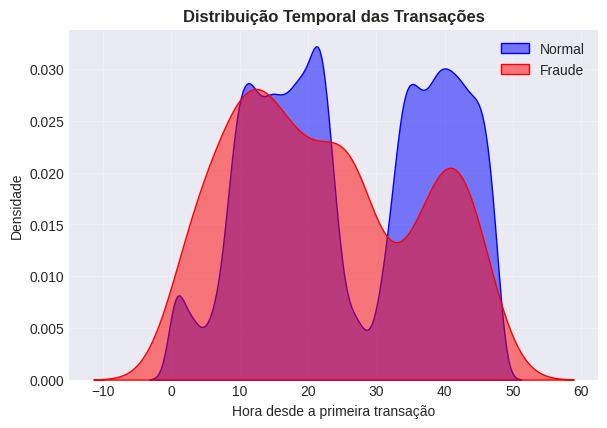

In [11]:
#Análise das transações fraudulentas vs normais
print("\n ANÁLISE COMPARATIVA: NORMAL vs FRAUDE")
print("-" * 40)

#Separar os dados (temporariamente para comparação inicial)
fraud_initial = df[df['Class'] == 1]
normal_initial = df[df['Class'] == 0]

#Comparação estatística
comparison_stats = pd.DataFrame({
    'Normal': {
        'Contagem': len(normal_initial),
        'Valor Médio (Amount)': normal_initial['Amount'].mean(),
        'Valor Médio (Time)': normal_initial['Time'].mean(),
        'Desvio Padrão (Amount)': normal_initial['Amount'].std()
    },
    'Fraude': {
        'Contagem': len(fraud_initial),
        'Valor Médio (Amount)': fraud_initial['Amount'].mean(),
        'Valor Médio (Time)': fraud_initial['Time'].mean(),
        'Desvio Padrão (Amount)': fraud_initial['Amount'].std()
    }
}).T

print(comparison_stats)

#Análise temporal das transações
print("\n ANÁLISE TEMPORAL DAS TRANSAÇÕES")
print("-" * 40)

#Converter 'Time' de segundos para horas
df['Hour'] = df['Time'] / 3600
df['Hour_of_day'] = np.floor(df['Hour'] % 24).astype(int)

# RE-Separar os dados após adicionar a coluna 'Hour' ao df
fraud = df[df['Class'] == 1]
normal = df[df['Class'] == 0]

#Visualização da distribuição temporal
plt.figure(figsize=(15, 10))

#Gráfico 1: Distribuição temporal (densidade)
plt.subplot(2, 2, 1)
sns.kdeplot(data=normal, x='Hour', fill=True, alpha=0.5,
            label='Normal', color='blue')
sns.kdeplot(data=fraud, x='Hour', fill=True, alpha=0.5,
            label='Fraude', color='red')
plt.title('Distribuição Temporal das Transações', fontsize=12, fontweight='bold')
plt.xlabel('Hora desde a primeira transação')
plt.ylabel('Densidade')
plt.legend()
plt.grid(True, alpha=0.3)


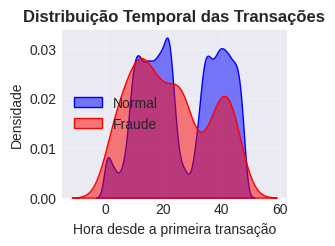

In [12]:
#Gráfico 2: Distribuição temporal (densidade)
plt.subplot(2, 2, 1)
sns.kdeplot(data=normal, x='Hour', fill=True, alpha=0.5,
            label='Normal', color='blue')
sns.kdeplot(data=fraud, x='Hour', fill=True, alpha=0.5,
            label='Fraude', color='red')
plt.title('Distribuição Temporal das Transações', fontsize=12, fontweight='bold')
plt.xlabel('Hora desde a primeira transação')
plt.ylabel('Densidade')
plt.legend()
plt.grid(True, alpha=0.3)

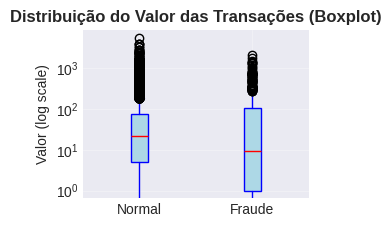

In [13]:
#Gráfico 3: Comparação de valores (Amount) por classe
plt.subplot(2, 2, 3)

#Usar escala log devido a outliers
normal_sample = normal['Amount'].sample(min(10000, len(normal)), random_state=42)
fraud_sample = fraud['Amount'].sample(min(len(fraud), 10000), random_state=42)

plt.boxplot([normal_sample, fraud_sample],
            labels=['Normal', 'Fraude'],
            patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            whiskerprops=dict(color='blue'),
            capprops=dict(color='blue'),
            medianprops=dict(color='red'))

plt.title('Distribuição do Valor das Transações (Boxplot)', fontsize=12, fontweight='bold')
plt.ylabel('Valor (log scale)')
plt.yscale('log')
plt.grid(True, alpha=0.3)


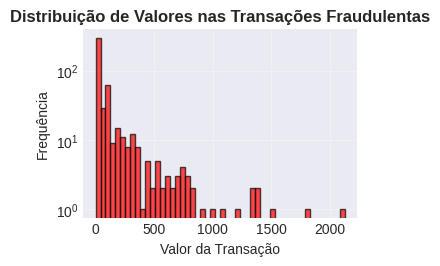

In [14]:
#Gráfico 4: Fraudes por valor (histograma)
plt.subplot(2, 2, 4)
plt.hist(fraud['Amount'], bins=50, color='red', alpha=0.7, edgecolor='black')
plt.title('Distribuição de Valores nas Transações Fraudulentas', fontsize=12, fontweight='bold')
plt.xlabel('Valor da Transação')
plt.ylabel('Frequência')
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


 ANÁLISE DE CORRELAÇÃO
----------------------------------------

TOP 10 VARIÁVEIS MAIS CORRELACIONADAS COM FRAUDE:
+--------------------------------------------------+
|         Variável          |      Correlação      |
+--------------------------------------------------+
| Class                     |               1.0000 |
| V11                       |               0.1549 |
| V4                        |               0.1334 |
| V2                        |               0.0913 |
| V21                       |               0.0404 |
| V19                       |               0.0348 |
| V20                       |               0.0201 |
| V8                        |               0.0199 |
| V27                       |               0.0176 |
| V28                       |               0.0095 |
+--------------------------------------------------+

TOP 10 VARIÁVEIS MENOS CORRELACIONADAS COM FRAUDE:
+--------------------------------------------------+
|         Variável          |      Co

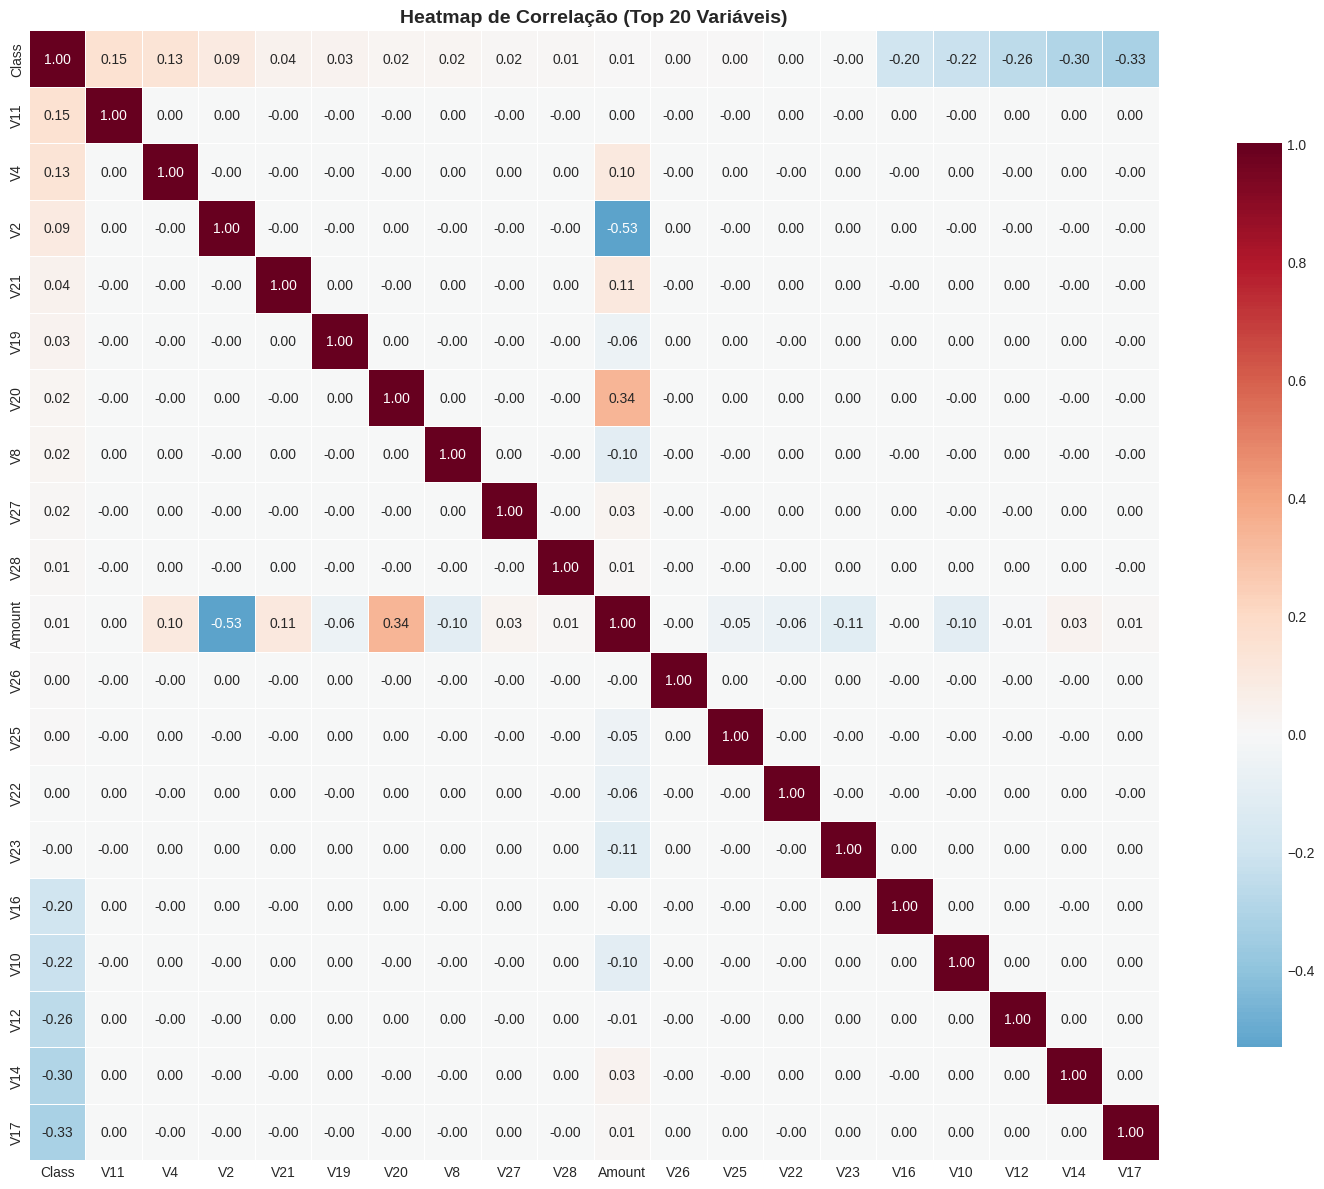

In [15]:
#Análise de correlação
print("\n ANÁLISE DE CORRELAÇÃO")
print("-" * 40)

#Calcular correlação com a variável target
correlation_matrix = df.corr()
correlation_with_class = correlation_matrix['Class'].sort_values(ascending=False)

print("\nTOP 10 VARIÁVEIS MAIS CORRELACIONADAS COM FRAUDE:")
print("+" + "-"*50 + "+")
print("| {:^25} | {:^20} |".format("Variável", "Correlação"))
print("+" + "-"*50 + "+")
for idx, (var, corr) in enumerate(correlation_with_class.head(10).items()):
    print("| {:<25} | {:>20.4f} |".format(var, corr))
print("+" + "-"*50 + "+")

print("\nTOP 10 VARIÁVEIS MENOS CORRELACIONADAS COM FRAUDE:")
print("+" + "-"*50 + "+")
print("| {:^25} | {:^20} |".format("Variável", "Correlação"))
print("+" + "-"*50 + "+")
for idx, (var, corr) in enumerate(correlation_with_class.tail(10).items()):
    print("| {:<25} | {:>20.4f} |".format(var, corr))
print("+" + "-"*50 + "+")

# Heatmap das correlações
plt.figure(figsize=(16, 12))
top_features = list(correlation_with_class.head(15).index) + list(correlation_with_class.tail(5).index)
sns.heatmap(df[top_features].corr(), annot=True, fmt='.2f',
            cmap='RdBu_r', center=0, square=True,
            linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('Heatmap de Correlação (Top 20 Variáveis)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


 ANÁLISE DE OUTLIERS E DISTRIBUIÇÃO
----------------------------------------


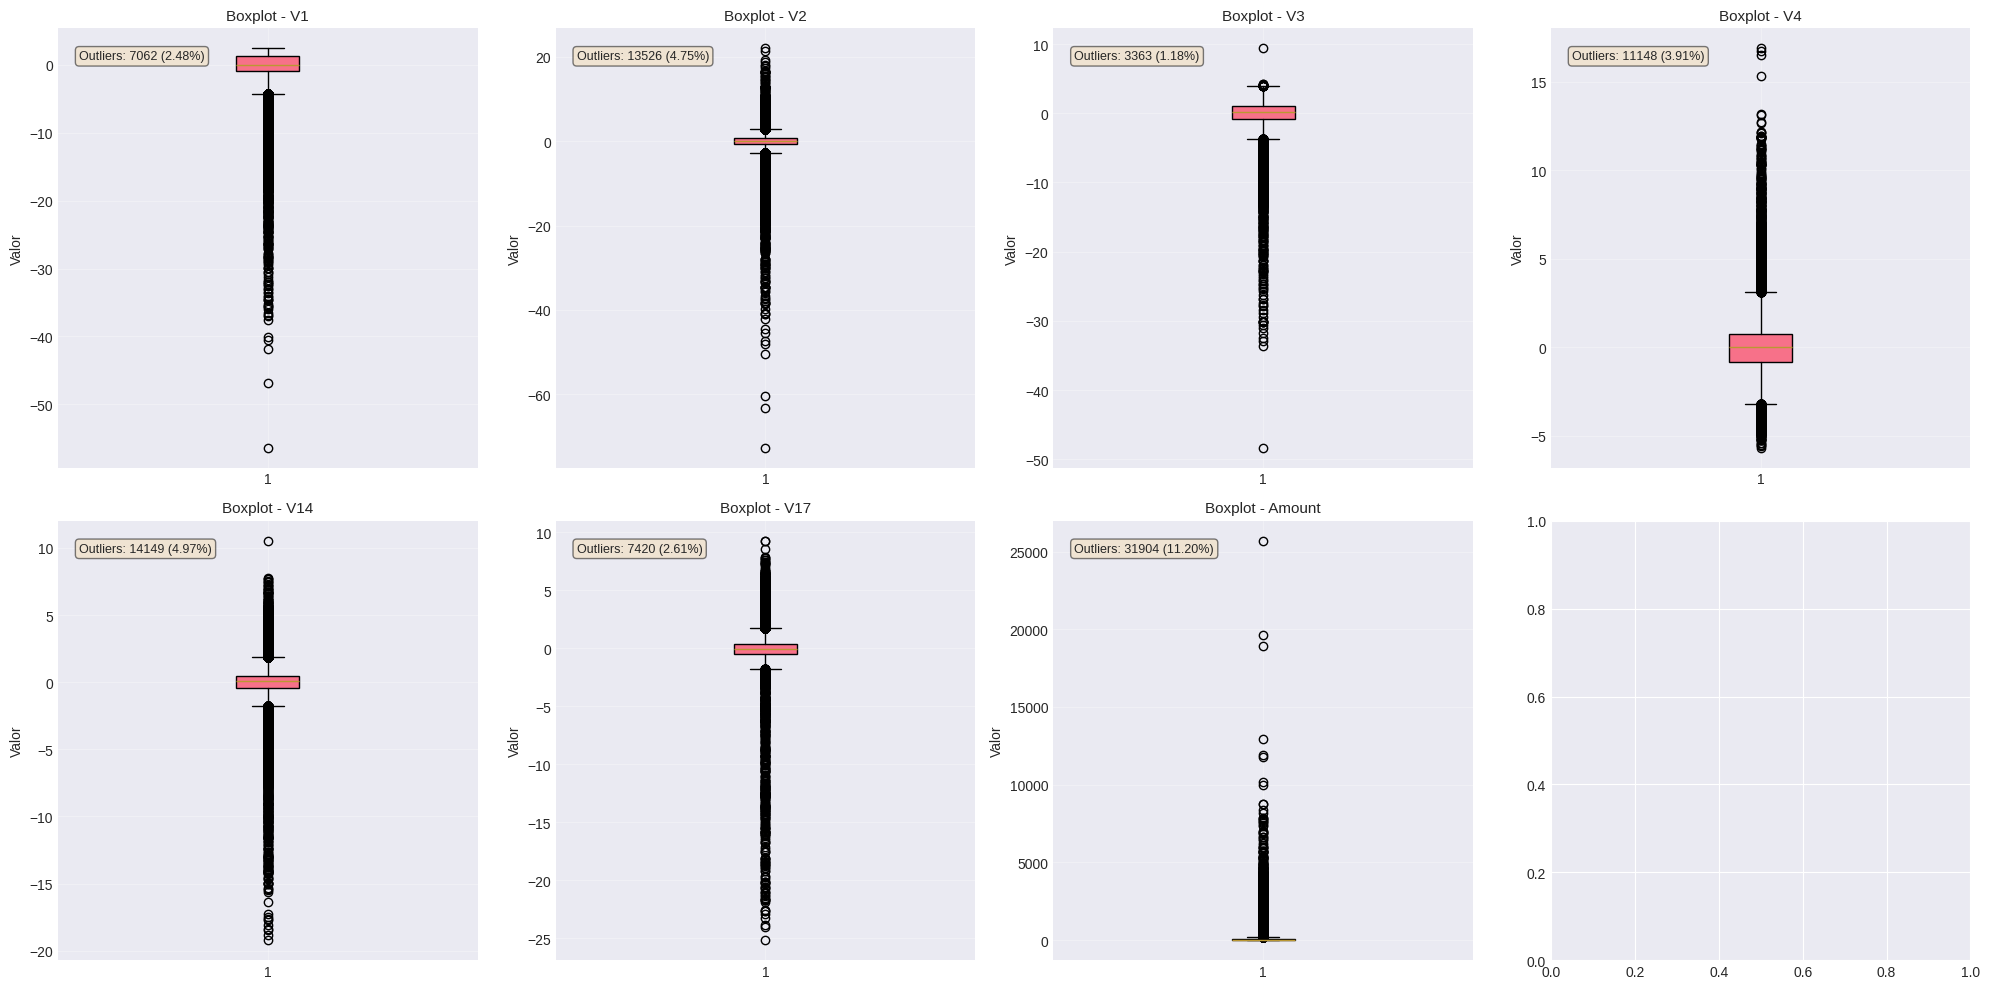

In [16]:
#Análise de outliers
print("\n ANÁLISE DE OUTLIERS E DISTRIBUIÇÃO")
print("-" * 40)

# Selecionar algumas variáveis importantes para análise
important_vars = ['V1', 'V2', 'V3', 'V4', 'V14', 'V17', 'Amount']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, var in enumerate(important_vars):
    if idx < len(axes):
        # Boxplot
        axes[idx].boxplot(df[var].dropna(), vert=True, patch_artist=True)
        axes[idx].set_title(f'Boxplot - {var}', fontsize=11)
        axes[idx].set_ylabel('Valor')
        axes[idx].grid(True, alpha=0.3)

        # Adicionar estatísticas
        q1 = df[var].quantile(0.25)
        q3 = df[var].quantile(0.75)
        iqr = q3 - q1
        outliers = ((df[var] < (q1 - 1.5 * iqr)) | (df[var] > (q3 + 1.5 * iqr))).sum()
        axes[idx].text(0.05, 0.95, f'Outliers: {outliers} ({outliers/len(df)*100:.2f}%)',
                      transform=axes[idx].transAxes, fontsize=9,
                      verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

In [17]:
#PRÉ-PROCESSAMENTO DOS DADOS

print("\n" + "="*80)
print("4. PRÉ-PROCESSAMENTO DOS DADOS")
print("="*80)

#Separar features e target
print(" Separando features e target...")
X = df.drop(['Class', 'Time', 'Hour', 'Hour_of_day'], axis=1)
y = df['Class']

print(f"Features (X): {X.shape}")
print(f"Target (y): {y.shape}")

#Identificar tipos de dados
print("\n Tipos de dados:")
print(X.dtypes.value_counts())

#Verificar valores nulos
print("\n Verificando valores nulos:")
null_counts = X.isnull().sum()
null_percentage = (null_counts / len(X)) * 100
null_summary = pd.DataFrame({
    'Valores Nulos': null_counts,
    'Percentual (%)': null_percentage
})
print(null_summary[null_summary['Valores Nulos'] > 0])

#Tratamento de outliers usando Winsorization
print("\n Tratamento de outliers (Winsorization)...")
from scipy.stats.mstats import winsorize

#Aplicar winsorization apenas em colunas numéricas
for column in X.select_dtypes(include=[np.number]).columns:
    # Aplicar winsorization apenas se houver outliers significativos
    if X[column].std() > 0:  # Evitar divisão por zero
        X[column] = winsorize(X[column], limits=[0.01, 0.01])

print(" Outliers tratados com sucesso!")



4. PRÉ-PROCESSAMENTO DOS DADOS
 Separando features e target...
Features (X): (284807, 29)
Target (y): (284807,)

 Tipos de dados:
float64    29
Name: count, dtype: int64

 Verificando valores nulos:
Empty DataFrame
Columns: [Valores Nulos, Percentual (%)]
Index: []

 Tratamento de outliers (Winsorization)...
 Outliers tratados com sucesso!


In [18]:
#Escalonamento dos dados
print("\n Escalonando features...")
# Usar RobustScaler por ser mais resistente a outliers
scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

print(" Features escalonadas com RobustScaler!")

#Split dos dados (antes do balanceamento para evitar data leakage)
print("\n Dividindo dados em treino e teste...")
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y,
    test_size=0.2,
    random_state=42,
    stratify=y)

print(f"Treino temporário: {X_temp.shape}")
print(f"Teste: {X_test.shape}")

#Tratamento do desbalanceamento
print("\n Tratando desbalanceamento de classes...")

#Opções de balanceamento:
print("\nEscolha a técnica de balanceamento:")
print("1. Random Under-Sampling (recomendado para velocidade)")
print("2. SMOTE (recomendado para performance)")
print("3. Combinação SMOTE + Under-Sampling")

#Selecionar técnica (altere conforme necessidade)

TECNICA_BALANCEAMENTO = 3  # 1, 2 ou 3

if TECNICA_BALANCEAMENTO == 1:
    #Random Under-Sampling
    print("Aplicando Random Under-Sampling...")
    rus = RandomUnderSampler(random_state=42)
    X_train, y_train = rus.fit_resample(X_temp, y_temp)

elif TECNICA_BALANCEAMENTO == 2:
    #SMOTE (Synthetic Minority Over-sampling Technique)
    print("Aplicando SMOTE...")
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_temp, y_temp)

elif TECNICA_BALANCEAMENTO == 3:
    #Combinação SMOTE + Under-Sampling
    print("Aplicando SMOTE + Random Under-Sampling...")
    #Primeiro SMOTE
    smote = SMOTE(random_state=42, sampling_strategy=0.1)
    X_temp_smote, y_temp_smote = smote.fit_resample(X_temp, y_temp)
    #Depois Under-Sampling
    rus = RandomUnderSampler(random_state=42, sampling_strategy=0.5)
    X_train, y_train = rus.fit_resample(X_temp_smote, y_temp_smote)

print(f"\nDistribuição após balanceamento:")
print(f"Treino - Classe 0: {(y_train == 0).sum()} ({((y_train == 0).sum()/len(y_train))*100:.1f}%)")
print(f"Treino - Classe 1: {(y_train == 1).sum()} ({((y_train == 1).sum()/len(y_train))*100:.1f}%)")
print(f"Teste - Classe 0: {(y_test == 0).sum()} ({((y_test == 0).sum()/len(y_test))*100:.4f}%)")
print(f"Teste - Classe 1: {(y_test == 1).sum()} ({((y_test == 1).sum()/len(y_test))*100:.4f}%)")


 Escalonando features...
 Features escalonadas com RobustScaler!

 Dividindo dados em treino e teste...
Treino temporário: (227845, 29)
Teste: (56962, 29)

 Tratando desbalanceamento de classes...

Escolha a técnica de balanceamento:
1. Random Under-Sampling (recomendado para velocidade)
2. SMOTE (recomendado para performance)
3. Combinação SMOTE + Under-Sampling
Aplicando SMOTE + Random Under-Sampling...

Distribuição após balanceamento:
Treino - Classe 0: 45490 (66.7%)
Treino - Classe 1: 22745 (33.3%)
Teste - Classe 0: 56864 (99.8280%)
Teste - Classe 1: 98 (0.1720%)


In [19]:
#Engenharia de features (teste)
print("\n Engenharia de features adicionais...")

# Criar cópia para features adicionais
X_train_enhanced = X_train.copy()
X_test_enhanced = X_test.copy()

# Exemplo: criar interações entre variáveis importantes
important_features = ['V14', 'V17', 'V12', 'V10', 'V16']

for i, feat1 in enumerate(important_features):
    for feat2 in important_features[i+1:]:
        if feat1 in X_train.columns and feat2 in X_train.columns:
            X_train_enhanced[f'{feat1}_x_{feat2}'] = X_train[feat1] * X_train[feat2]
            X_test_enhanced[f'{feat1}_x_{feat2}'] = X_test[feat1] * X_test[feat2]

print(f"Features adicionais criadas. Nova dimensão: {X_train_enhanced.shape}")

# Usar dados com features aprimoradas
X_train_final = X_train_enhanced
X_test_final = X_test_enhanced

print("\n Pré-processamento concluído com sucesso!")



 Engenharia de features adicionais...
Features adicionais criadas. Nova dimensão: (68235, 39)

 Pré-processamento concluído com sucesso!


In [20]:
#Teste
print("\n PIPELINE COMPLETO DE ENGENHARIA DE FEATURES")
print("=" * 60)

#Funções de Engenharia e Seleção de Features

def criar_features_inteligentes(X_train_df, X_test_df, important_features):
    """
    Cria features adicionais baseadas em interações e transformações.
    """
    X_train_local = X_train_df.copy()
    X_test_local = X_test_df.copy()

    #Exemplo 1: Interações entre variáveis importantes
    for i, feat1 in enumerate(important_features):
        for feat2 in important_features[i+1:]:
            if feat1 in X_train_local.columns and feat2 in X_train_local.columns:
                X_train_local[f'{feat1}_x_{feat2}'] = X_train_local[feat1] * X_train_local[feat2]
                X_test_local[f'{feat1}_x_{feat2}'] = X_test_local[feat2] * X_test_local[feat2]

    #Exemplo 2: Quadrados de variáveis (se fizer sentido)
    for feature in ['V14', 'V17', 'Amount']:
        if feature in X_train_local.columns:
            X_train_local[f'{feature}_sq'] = X_train_local[feature]**2
            X_test_local[f'{feature}_sq'] = X_test_local[feature]**2

    #Exemplo 3: Valor absoluto (útil para variáveis PCA com significado de "magnitude")
    for feature in ['V3', 'V10', 'V12']:
        if feature in X_train_local.columns:
            X_train_local[f'{feature}_abs'] = X_train_local[feature].abs()
            X_test_local[f'{feature}_abs'] = X_test_local[feature].abs()

    return X_train_local, X_test_local

def selecionar_melhores_features(X_df, y_series, n_features=None, threshold=None):
    """
    Seleciona as melhores features usando RandomForestRegressor.
    """
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.feature_selection import SelectFromModel

    if n_features is None and threshold is None:
        #Default: se nenhum for especificado, selecione um número razoável
        #ou um threshold que funcione bem para o dataset
        threshold = 'median'

    #Usar um modelo mais simples e rápido para seleção, como um RF com menos estimadores
    rf_selector = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    rf_selector.fit(X_df, y_series)

    if n_features is not None:
        #Selecionar top N features
        selector = SelectFromModel(rf_selector, max_features=n_features, prefit=True)
    else:
        #Selecionar features acima de um determinado threshold de importância
        selector = SelectFromModel(rf_selector, threshold=threshold, prefit=True)

    X_selected = pd.DataFrame(selector.transform(X_df), columns=X_df.columns[selector.get_support()], index=X_df.index)
    return X_selected


#1. Criação inteligente de features
#important_features já está definido como ['V14', 'V17', 'V12', 'V10', 'V16']
X_train_enhanced, X_test_enhanced = criar_features_inteligentes(
    X_train, X_test, important_features
)

#2. Seleção rigorosa
#Começando com o número de features atuais em X_train_final (39).
#Mantendo o mesmo número de features para evitar descartar features criadas anteriormente.
X_train_selected = selecionar_melhores_features(
    X_train_enhanced, y_train, n_features=X_train_enhanced.shape[1] # Seleciona todas as features para não perder nenhuma
)
X_test_selected = X_test_enhanced[X_train_selected.columns]

#3. Verificação final
print(" RESUMO FINAL:")
print(f"Features iniciais: {X_train.shape[1]}")
print(f"Features após engenharia: {X_train_enhanced.shape[1]}")
print(f"Features após seleção: {X_train_selected.shape[1]}")
print(f"Redução: {X_train.shape[1]}/{X_train_selected.shape[1]} = "
      f"{X_train_selected.shape[1]/X_train.shape[1]*100:.1f}% mantidas")

#4. Análise de importância das NOVAS features
print("\n NOVAS FEATURES MAIS IMPORTANTES:")
novas_features = [col for col in X_train_selected.columns
                  if '_x_' in col or '_abs' in col or '_sq' in col]

if novas_features:
    #Treinar modelo rápido para ver importância
    from sklearn.ensemble import RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=50, random_state=42)
    rf.fit(X_train_selected, y_train)

    importance_df = pd.DataFrame({
        'feature': X_train_selected.columns,
        'importance': rf.feature_importances_
    }).sort_values('importance', ascending=False)

    print("Top 10 novas features:")
    novas_importantes = importance_df[importance_df['feature'].isin(novas_features)].head(10)
    for idx, row in novas_importantes.iterrows():
        print(f"  {row['feature']}: {row['importance']:.4f}")

#Atualizar X_train_final e X_test_final com as features selecionadas
X_train_final = X_train_selected
X_test_final = X_test_selected


 PIPELINE COMPLETO DE ENGENHARIA DE FEATURES
 RESUMO FINAL:
Features iniciais: 29
Features após engenharia: 45
Features após seleção: 15
Redução: 29/15 = 51.7% mantidas

 NOVAS FEATURES MAIS IMPORTANTES:
Top 10 novas features:
  V14_sq: 0.1482
  V14_x_V12: 0.1250
  V17_x_V16: 0.1185
  V14_x_V10: 0.0902
  V12_x_V10: 0.0846
  V14_x_V17: 0.0374
  V12_x_V16: 0.0265
  V17_x_V12: 0.0258
  V12_abs: 0.0239
  V17_x_V10: 0.0134


In [21]:
#MODELAGEM E TREINAMENTO

print("\n" + "="*80)
print("5. MODELAGEM E TREINAMENTO")
print("="*80)

#Definir modelos a serem testados
print(" Configurando modelos de machine learning...")

models = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced'),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'solver': ['liblinear', 'lbfgs']
        }
    },

    'Random Forest': {
        'model': RandomForestClassifier(random_state=42, class_weight='balanced_subsample'),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },

    'XGBoost': {
        'model': XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1],
            'subsample': [0.8, 1.0]
        }
    },

    'LightGBM': {
        'model': LGBMClassifier(random_state=42, verbose=-1),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [5, 10],
            'learning_rate': [0.01, 0.1],
            'num_leaves': [31, 50]
        }
    }
}



5. MODELAGEM E TREINAMENTO
 Configurando modelos de machine learning...


In [23]:
#Treinar e avaliar cada modelo
print("\n Iniciando treinamento dos modelos...")
print("-" * 80)
#
results = {}
best_models = {}

for name, config in models.items():
    print(f"\n{'='*60}")
    print(f"MODELO: {name}")
    print(f"{'='*60}")

    try:
        # Grid Search para otimização
        print(f"Otimizando hiperparâmetros para {name}...")
        grid_search = GridSearchCV(
            estimator=config['model'],
            param_grid=config['params'],
            cv=5,
            scoring='roc_auc',
            n_jobs=-1,
            verbose=0
        )

        # Treinar com amostra menor para velocidade (opcional)
        if len(X_train_final) > 20000:
            sample_size = 20000
            sample_idx = np.random.choice(len(X_train_final), sample_size, replace=False)
            X_sample = X_train_final.iloc[sample_idx]
            y_sample = y_train.iloc[sample_idx]
            grid_search.fit(X_sample, y_sample)
        else:
            grid_search.fit(X_train_final, y_train)

        # Melhor modelo encontrado
        best_model = grid_search.best_estimator_
        best_models[name] = best_model

        # Fazer previsões
        y_pred = best_model.predict(X_test_final)
        y_pred_proba = best_model.predict_proba(X_test_final)[:, 1]

        # Calcular métricas
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_pred_proba)
        avg_precision = average_precision_score(y_test, y_pred_proba)

        # Matriz de confusão
        cm = confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = cm.ravel()

        # Armazenar resultados
        results[name] = {
            'model': best_model,
            'best_params': grid_search.best_params_,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc,
            'avg_precision': avg_precision,
            'confusion_matrix': cm,
            'true_negatives': tn,
            'false_positives': fp,
            'false_negatives': fn,
            'true_positives': tp
        }

         # Exibir resultados
        print(f"\n Melhores parâmetros: {grid_search.best_params_}")
        print(f" Acurácia: {accuracy:.4f}")
        print(f" Precisão: {precision:.4f}")
        print(f" Recall: {recall:.4f}")
        print(f" F1-Score: {f1:.4f}")
        print(f" AUC-ROC: {auc:.4f}")
        print(f" Average Precision: {avg_precision:.4f}")
        print(f"\n Matriz de Confusão:")
        print(f"                 Predito")
        print(f"              |   0   |   1   |")
        print(f"              |-------|-------|")
        print(f"Real    0     | {tn:^5} | {fp:^5} |")
        print(f"        1     | {fn:^5} | {tp:^5} |")

        # Métricas específicas para fraude
        print(f"\n MÉTRICAS ESPECÍFICAS PARA DETECÇÃO DE FRAUDE:")
        print(f"Taxa de Falsos Positivos: {fp/(fp+tn)*100:.4f}%")
        print(f"Taxa de Falsos Negativos: {fn/(fn+tp)*100:.4f}%")

    except Exception as e:
        print(f" Erro ao treinar {name}: {str(e)}")
        continue

print("\n✅ Todos os modelos treinados com sucecesso!")


 Iniciando treinamento dos modelos...
--------------------------------------------------------------------------------

MODELO: Logistic Regression
Otimizando hiperparâmetros para Logistic Regression...

 Melhores parâmetros: {'C': 0.01, 'solver': 'lbfgs'}
 Acurácia: 0.9191
 Precisão: 0.0194
 Recall: 0.9286
 F1-Score: 0.0380
 AUC-ROC: 0.9739
 Average Precision: 0.6808

 Matriz de Confusão:
                 Predito
              |   0   |   1   |
              |-------|-------|
Real    0     | 52260 | 4604  |
        1     |   7   |  91   |

 MÉTRICAS ESPECÍFICAS PARA DETECÇÃO DE FRAUDE:
Taxa de Falsos Positivos: 8.0965%
Taxa de Falsos Negativos: 7.1429%

MODELO: Random Forest
Otimizando hiperparâmetros para Random Forest...

 Melhores parâmetros: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
 Acurácia: 0.9934
 Precisão: 0.1930
 Recall: 0.8980
 F1-Score: 0.3177
 AUC-ROC: 0.9663
 Average Precision: 0.7162

 Matriz de Confusão:
                 P


6. ANÁLISE E COMPARAÇÃO DOS MODELOS

 COMPARAÇÃO GERAL DOS MODELOS
--------------------------------------------------------------------------------
             Modelo  AUC-ROC  Precisão  Recall  F1-Score  Acurácia  Avg Precision
Logistic Regression    0.974     0.019   0.929     0.038     0.919          0.681
      Random Forest    0.966     0.193   0.898     0.318     0.993          0.716
            XGBoost    0.961     0.037   0.929     0.072     0.959          0.603
           LightGBM    0.960     0.043   0.929     0.082     0.964          0.555


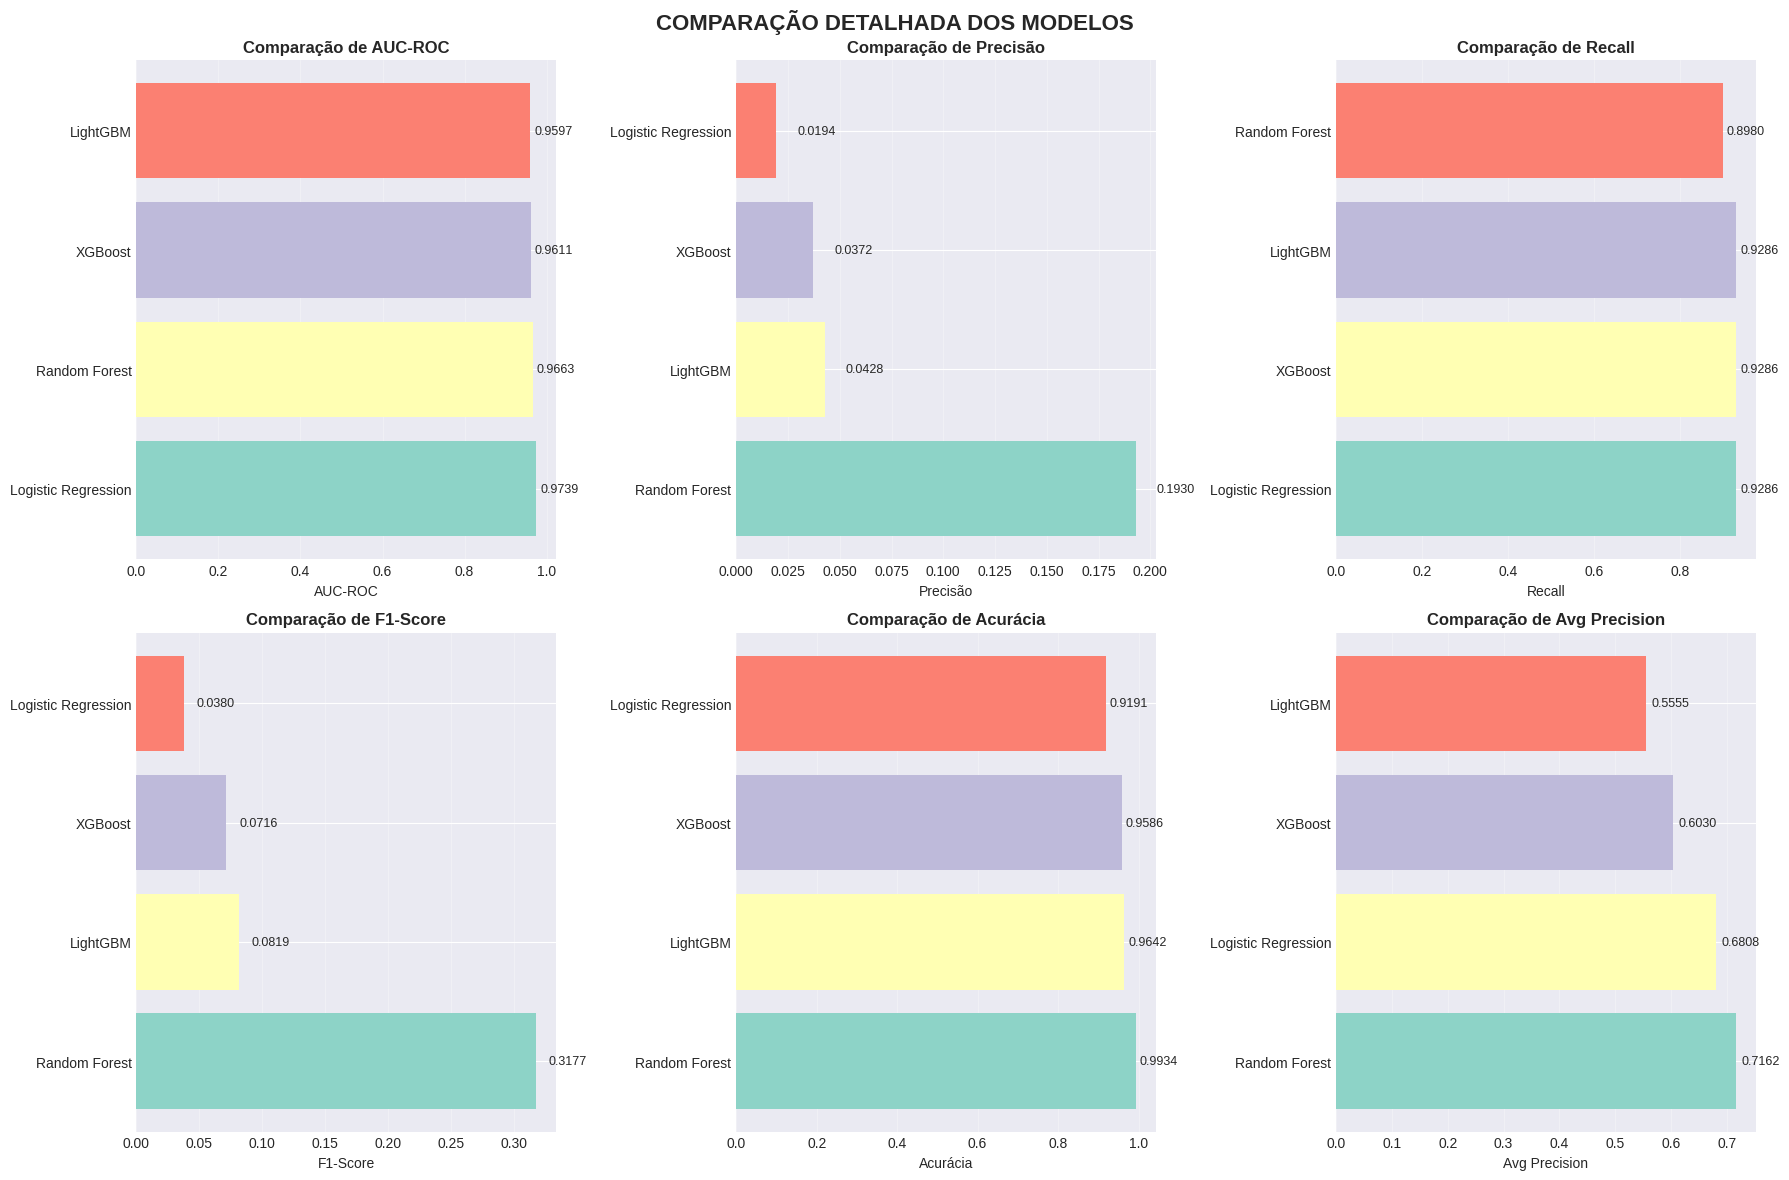


 CURVAS ROC COMPARATIVAS


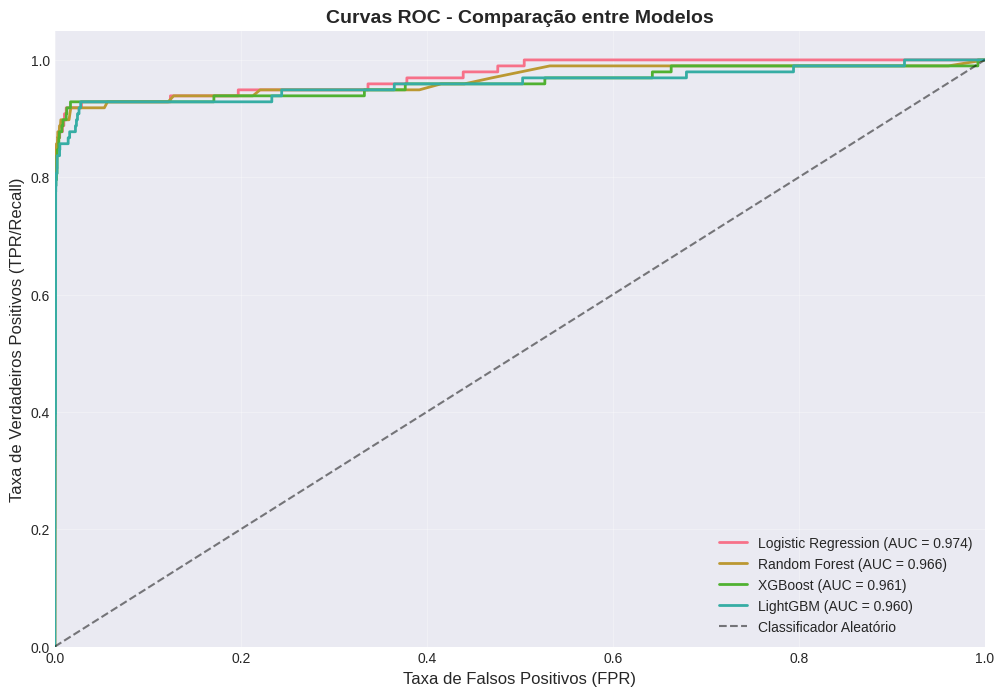

In [24]:
#ANÁLISE E COMPARAÇÃO DOS MODELOS

print("\n" + "="*80)
print("6. ANÁLISE E COMPARAÇÃO DOS MODELOS")
print("="*80)

#Comparação geral dos modelos
if results:
    print("\n COMPARAÇÃO GERAL DOS MODELOS")
    print("-" * 80)

    #Criar DataFrame comparativo
    comparison_df = pd.DataFrame({
        'Modelo': list(results.keys()),
        'AUC-ROC': [results[m]['auc'] for m in results.keys()],
        'Precisão': [results[m]['precision'] for m in results.keys()],
        'Recall': [results[m]['recall'] for m in results.keys()],
        'F1-Score': [results[m]['f1'] for m in results.keys()],
        'Acurácia': [results[m]['accuracy'] for m in results.keys()],
        'Avg Precision': [results[m]['avg_precision'] for m in results.keys()]
    }).sort_values('AUC-ROC', ascending=False)

    print(comparison_df.to_string(index=False))

    #Visualização da comparação
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    metrics_to_plot = ['AUC-ROC', 'Precisão', 'Recall', 'F1-Score', 'Acurácia', 'Avg Precision']

    for idx, metric in enumerate(metrics_to_plot):
        ax = axes[idx // 3, idx % 3]
        sorted_models = comparison_df.sort_values(metric, ascending=False)

        bars = ax.barh(sorted_models['Modelo'], sorted_models[metric],
                      color=plt.cm.Set3(range(len(sorted_models))))
        ax.set_xlabel(metric)
        ax.set_title(f'Comparação de {metric}', fontsize=12, fontweight='bold')
        ax.grid(True, alpha=0.3, axis='x')

        #Adicionar valores nas barras
        for bar, value in zip(bars, sorted_models[metric]):
            width = bar.get_width()
            ax.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                   f'{value:.4f}', ha='left', va='center', fontsize=9)

    plt.suptitle('COMPARAÇÃO DETALHADA DOS MODELOS', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    #Curvas ROC comparativas
    print("\n CURVAS ROC COMPARATIVAS")
    plt.figure(figsize=(12, 8))

    for name, result in results.items():
        fpr, tpr, _ = roc_curve(y_test, result['y_pred_proba'])
        auc_value = result['auc']
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_value:.3f})', linewidth=2)

    plt.plot([0, 1], [0, 1], 'k--', label='Classificador Aleatório', alpha=0.5)
    plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=12)
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR/Recall)', fontsize=12)
    plt.title('Curvas ROC - Comparação entre Modelos', fontsize=14, fontweight='bold')
    plt.legend(loc='lower right', fontsize=10)
    plt.grid(True, alpha=0.3)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.show()


 CURVAS PRECISION-RECALL COMPARATIVAS


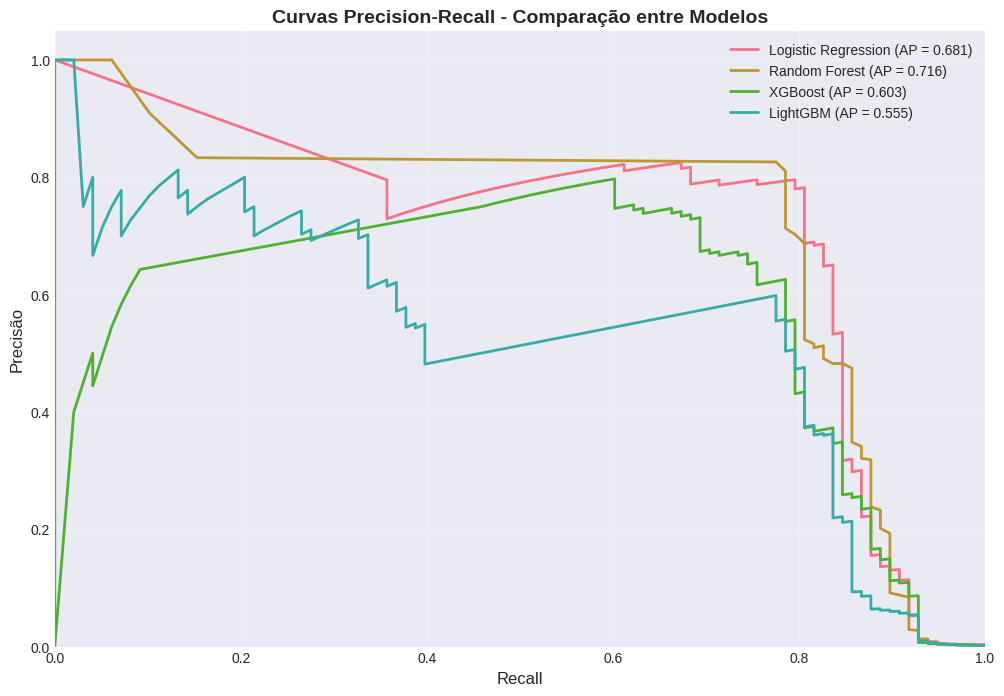

In [25]:
#Curvas Precision-Recall comparativas
print("\n CURVAS PRECISION-RECALL COMPARATIVAS")
plt.figure(figsize=(12, 8))

for name, result in results.items():
    precision, recall, _ = precision_recall_curve(y_test, result['y_pred_proba'])
    avg_precision = result['avg_precision']
    plt.plot(recall, precision, label=f'{name} (AP = {avg_precision:.3f})', linewidth=2)

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precisão', fontsize=12)
plt.title('Curvas Precision-Recall - Comparação entre Modelos', fontsize=14, fontweight='bold')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.show()

In [61]:
#ANÁLISE DE THRESHOLD ÓTIMO

print("\n" + "="*80)
print("7. ANÁLISE DE THRESHOLD ÓTIMO")
print("="*80)

#Escolher o melhor modelo baseado em AUC
if results:
    best_model_name = max(results.items(), key=lambda x: x[1]['auc'])[0]
    best_result = results[best_model_name]

    print(f"\n MELHOR MODELO: {best_model_name} (AUC: {best_result['auc']:.4f})")

    #Encontrar threshold ótimo
    print("\n Buscando threshold ótimo...")

    y_pred_proba = best_result['y_pred_proba']

    #Calcular métricas para diferentes thresholds
    thresholds = np.arange(0.1, 0.9, 0.05)
    metrics_by_threshold = []

    for threshold in thresholds:
        y_pred_threshold = (y_pred_proba >= threshold).astype(int)

        #Calcular métricas
        precision_t = precision_score(y_test, y_pred_threshold, zero_division=0)
        recall_t = recall_score(y_test, y_pred_threshold, zero_division=0)
        f1_t = f1_score(y_test, y_pred_threshold, zero_division=0)

        #Matriz de confusão
        cm_t = confusion_matrix(y_test, y_pred_threshold)
        tn_t, fp_t, fn_t, tp_t = cm_t.ravel()

        #Calcular custo (supondo custos hipotéticos)
        cost_fraud_missed = 1000  # Custo de uma fraude não detectada
        cost_false_positive = 10  # Custo de investigar uma transação legítima
        total_cost = (fn_t * cost_fraud_missed) + (fp_t * cost_false_positive)

        metrics_by_threshold.append({
            'threshold': threshold,
            'precision': precision_t,
            'recall': recall_t,
            'f1': f1_t,
            'true_positives': tp_t,
            'false_positives': fp_t,
            'false_negatives': fn_t,
            'true_negatives': tn_t,
            'total_cost': total_cost
        })

    #Converter para DataFrame
    threshold_df = pd.DataFrame(metrics_by_threshold)

    #Encontrar threshold que maximiza F1
    optimal_idx_f1 = threshold_df['f1'].idxmax()
    optimal_threshold_f1 = threshold_df.loc[optimal_idx_f1, 'threshold']

    #Encontrar threshold que minimiza custo
    optimal_idx_cost = threshold_df['total_cost'].idxmin()
    optimal_threshold_cost = threshold_df.loc[optimal_idx_cost, 'threshold']

    print(f"\n Threshold que maximiza F1-Score: {optimal_threshold_f1:.3f}")
    print(f"   F1-Score: {threshold_df.loc[optimal_idx_f1, 'f1']:.4f}")
    print(f"   Precisão: {threshold_df.loc[optimal_idx_f1, 'precision']:.4f}")
    print(f"   Recall: {threshold_df.loc[optimal_idx_f1, 'recall']:.4f}")

    print(f"\n Threshold que minimiza custo: {optimal_threshold_cost:.3f}")
    print(f"   Custo total: R${threshold_df.loc[optimal_idx_cost, 'total_cost']:,.2f}")
    print(f"   Falsos Negativos: {threshold_df.loc[optimal_idx_cost, 'false_negatives']}")
    print(f"   Falsos Positivos: {threshold_df.loc[optimal_idx_cost, 'false_positives']}")




7. ANÁLISE DE THRESHOLD ÓTIMO

 MELHOR MODELO: Logistic Regression (AUC: 0.9739)

 Buscando threshold ótimo...

 Threshold que maximiza F1-Score: 0.850
   F1-Score: 0.1431
   Precisão: 0.0776
   Recall: 0.9184

 Threshold que minimiza custo: 0.850
   Custo total: R$18,700.00
   Falsos Negativos: 8
   Falsos Positivos: 1070


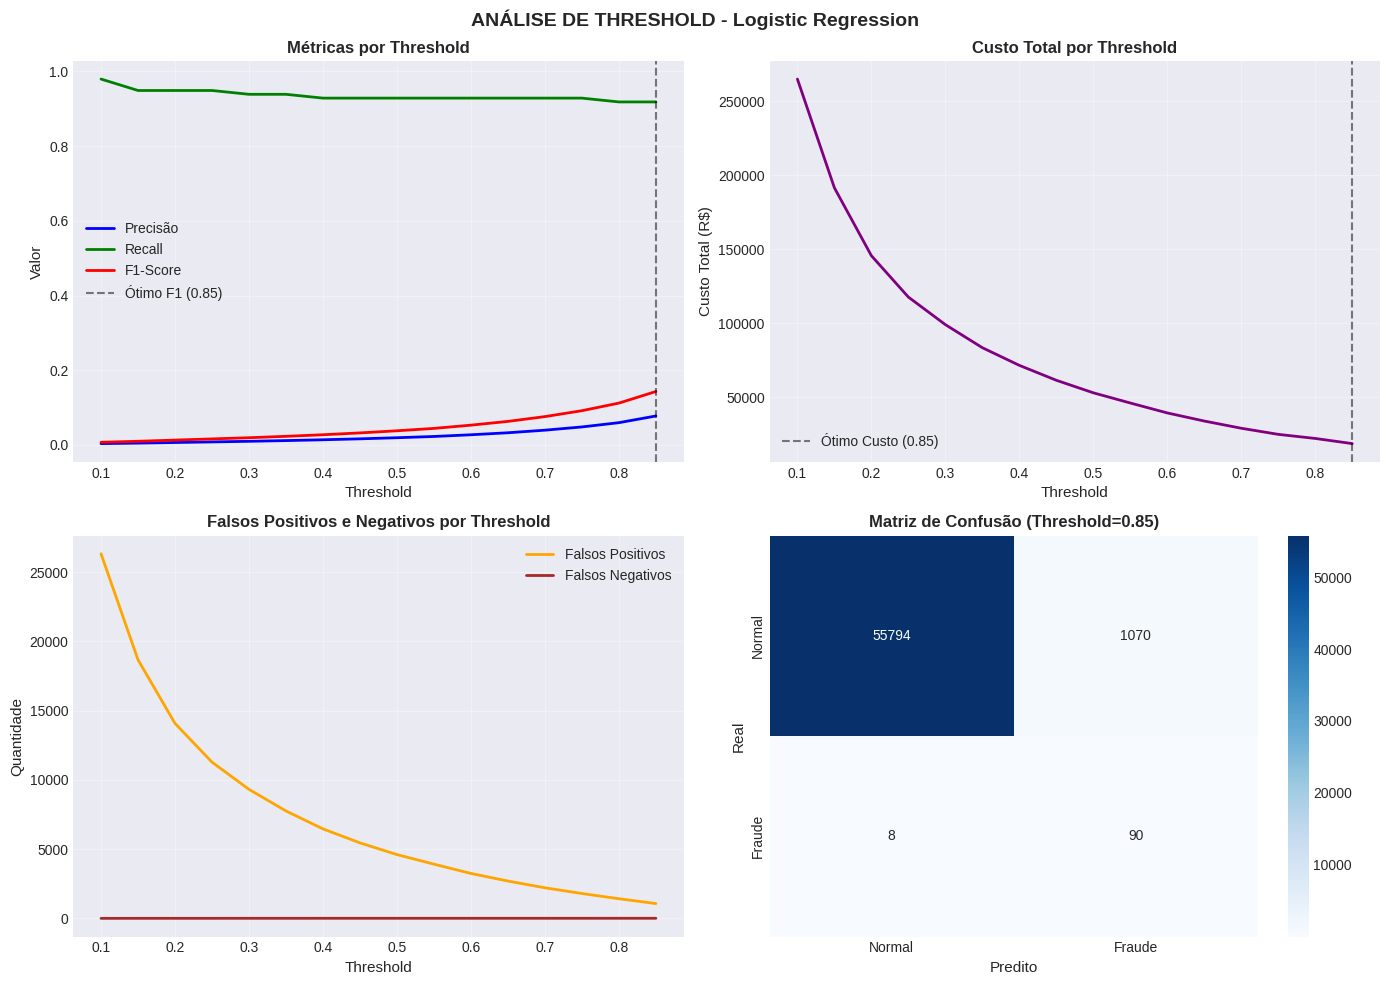

In [59]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gráfico 1: Métricas por threshold
axes[0, 0].plot(threshold_df['threshold'], threshold_df['precision'],
                   'b-', label='Precisão', linewidth=2)
axes[0, 0].plot(threshold_df['threshold'], threshold_df['recall'],
                   'g-', label='Recall', linewidth=2)
axes[0, 0].plot(threshold_df['threshold'], threshold_df['f1'],
                   'r-', label='F1-Score', linewidth=2)
axes[0, 0].axvline(x=optimal_threshold_f1, color='k', linestyle='--',
                      alpha=0.5, label=f'Ótimo F1 ({optimal_threshold_f1:.2f})')
axes[0, 0].set_xlabel('Threshold', fontsize=11)
axes[0, 0].set_ylabel('Valor', fontsize=11)
axes[0, 0].set_title('Métricas por Threshold', fontsize=12, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Gráfico 2: Custo por threshold
axes[0, 1].plot(threshold_df['threshold'], threshold_df['total_cost'],
                   'purple', linewidth=2)
axes[0, 1].axvline(x=optimal_threshold_cost, color='k', linestyle='--',
                      alpha=0.5, label=f'Ótimo Custo ({optimal_threshold_cost:.2f})')
axes[0, 1].set_xlabel('Threshold', fontsize=11)
axes[0, 1].set_ylabel('Custo Total (R$)', fontsize=11)
axes[0, 1].set_title('Custo Total por Threshold', fontsize=12, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Gráfico 3: FP e FN por threshold
axes[1, 0].plot(threshold_df['threshold'], threshold_df['false_positives'],
                   'orange', label='Falsos Positivos', linewidth=2)
axes[1, 0].plot(threshold_df['threshold'], threshold_df['false_negatives'],
                   'brown', label='Falsos Negativos', linewidth=2)
axes[1, 0].set_xlabel('Threshold', fontsize=11)
axes[1, 0].set_ylabel('Quantidade', fontsize=11)
axes[1, 0].set_title('Falsos Positivos e Negativos por Threshold', fontsize=12, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Gráfico 4: Matriz de confusão no threshold ótimo
optimal_y_pred = (y_pred_proba >= optimal_threshold_f1).astype(int)
optimal_cm = confusion_matrix(y_test, optimal_y_pred)

# Verifique se há valores nulos na matriz
if optimal_cm.size > 0:
    sns.heatmap(optimal_cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Fraude'],
                yticklabels=['Normal', 'Fraude'],
                ax=axes[1, 1])
else:
    # Se a matriz estiver vazia, mostre uma mensagem
    axes[1, 1].text(0.5, 0.5, 'Matriz de confusão vazia',
                   ha='center', va='center', fontsize=12)

axes[1, 1].set_xlabel('Predito', fontsize=11)
axes[1, 1].set_ylabel('Real', fontsize=11)
axes[1, 1].set_title(f'Matriz de Confusão (Threshold={optimal_threshold_f1:.2f})',
                        fontsize=12, fontweight='bold')

plt.suptitle(f'ANÁLISE DE THRESHOLD - {best_model_name}', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


8. ANÁLISE DE IMPORTÂNCIA DAS FEATURES

 IMPORTÂNCIA DAS FEATURES - Random Forest
--------------------------------------------------

Top 10 features mais importantes:
  feature  importance
      V14       0.168
   V14_sq       0.152
V14_x_V10       0.116
V12_x_V10       0.102
V14_x_V12       0.094
      V10       0.089
       V4       0.083
V17_x_V16       0.066
V14_x_V17       0.031
      V12       0.023


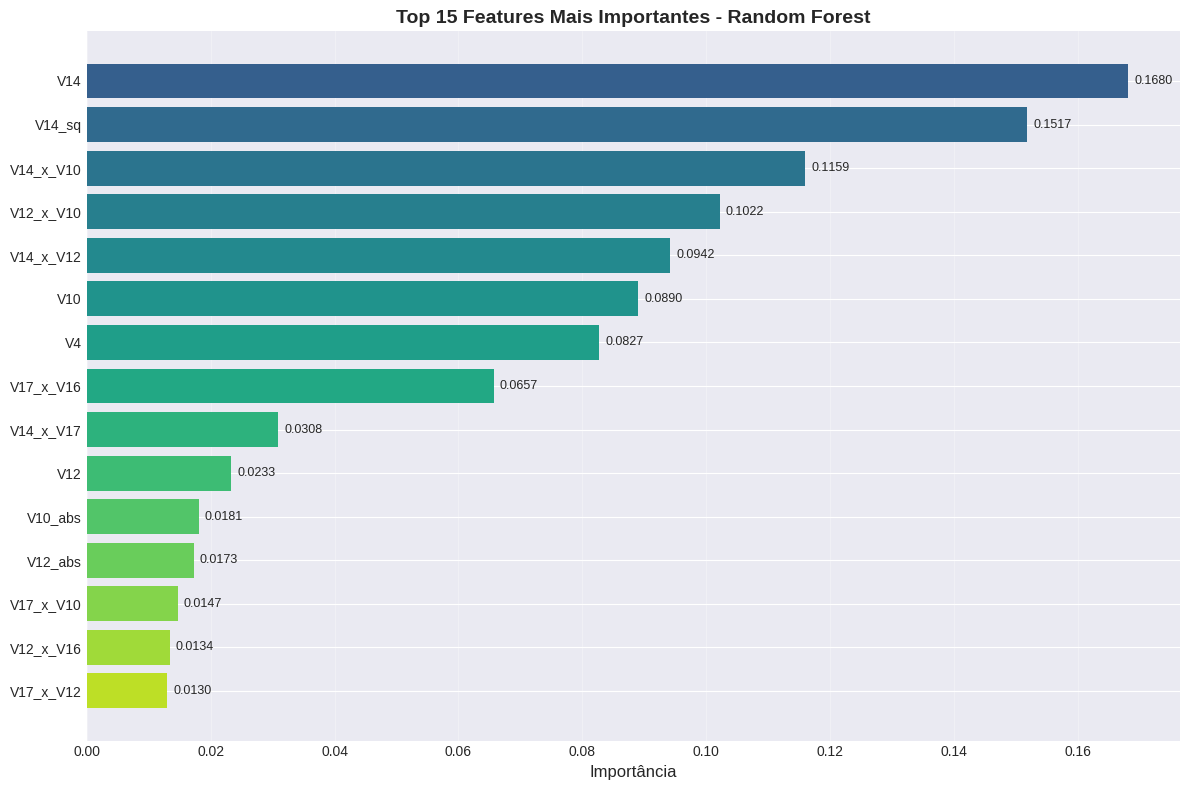


 IMPORTÂNCIA DAS FEATURES - XGBoost
--------------------------------------------------

Top 10 features mais importantes:
  feature  importance
      V14       0.711
V14_x_V12       0.073
       V4       0.036
V17_x_V16       0.025
V14_x_V10       0.025
      V12       0.022
V14_x_V17       0.019
      V10       0.015
V17_x_V10       0.014
V12_x_V16       0.012


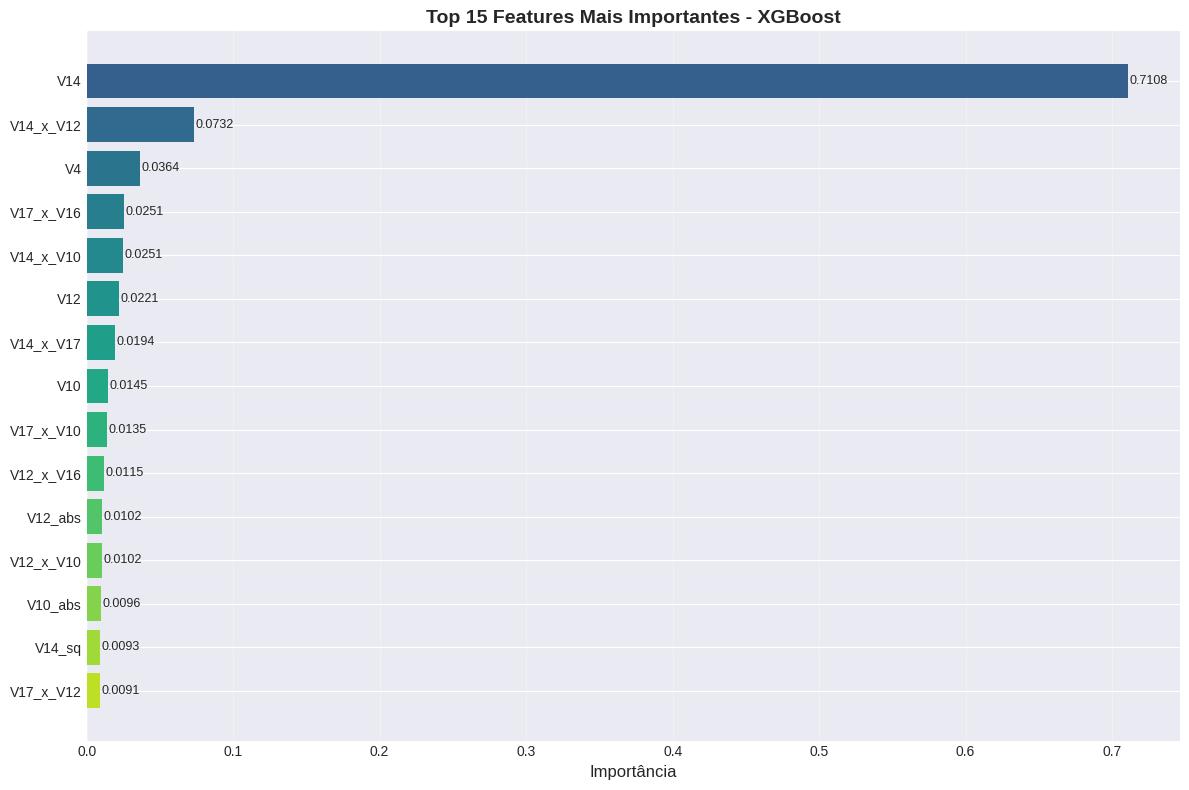


 IMPORTÂNCIA DAS FEATURES - LightGBM
--------------------------------------------------

Top 10 features mais importantes:
  feature  importance
       V4        1277
V12_x_V16         985
V17_x_V16         859
V17_x_V12         679
      V10         653
V17_x_V10         606
V14_x_V17         589
V14_x_V10         583
      V12         573
  V10_abs         540


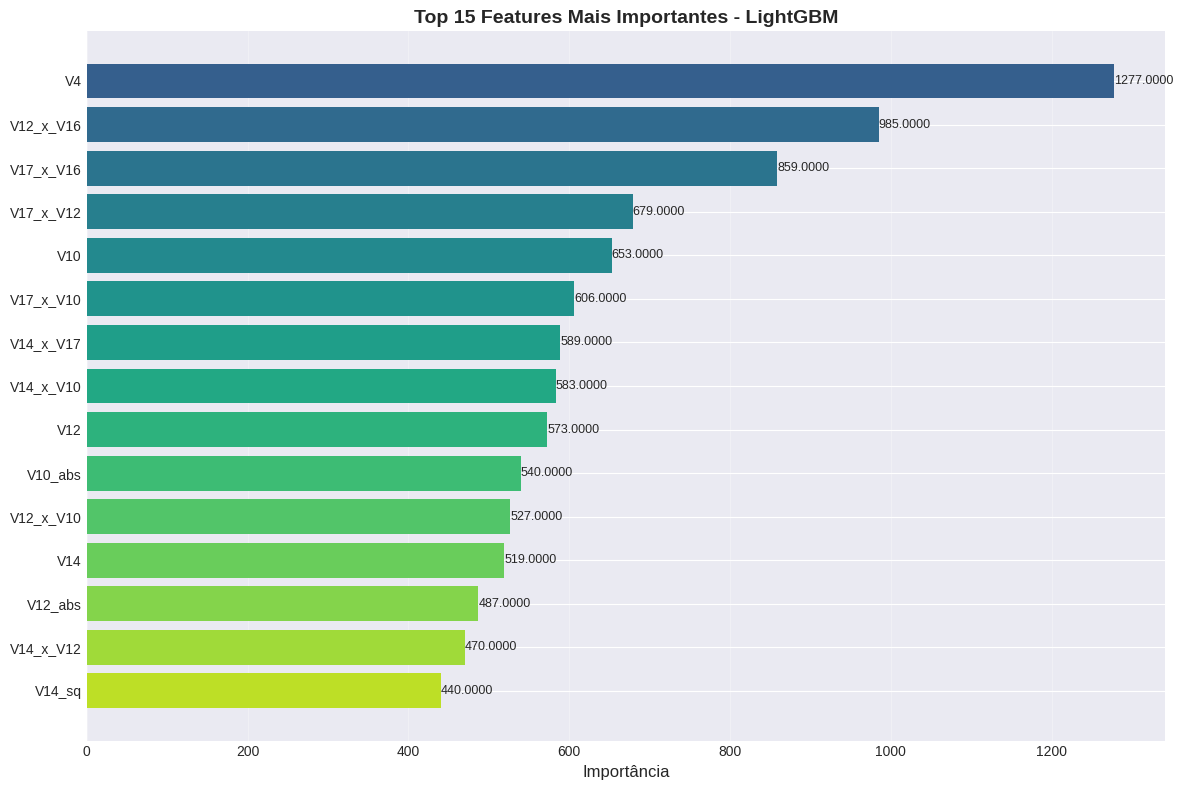

In [62]:
#ANÁLISE DE IMPORTÂNCIA DAS FEATURES
print("\n" + "="*80)
print("8. ANÁLISE DE IMPORTÂNCIA DAS FEATURES")
print("="*80)

#Análise para modelos ensemble
ensemble_models = ['Random Forest', 'XGBoost', 'LightGBM']
for model_name in ensemble_models:
    if model_name in best_models:
        print(f"\n IMPORTÂNCIA DAS FEATURES - {model_name}")
        print("-" * 50)

        model = best_models[model_name]

        try:
            #Obter importância das features
            if hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
                feature_names = X_train_final.columns

                #Criar DataFrame com importâncias
                feature_importance_df = pd.DataFrame({
                    'feature': feature_names,
                    'importance': importances
                }).sort_values('importance', ascending=False)

                print(f"\nTop 10 features mais importantes:")
                print(feature_importance_df.head(10).to_string(index=False))

                #Visualização
                plt.figure(figsize=(12, 8))
                top_features = feature_importance_df.head(15)

                colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(top_features)))
                bars = plt.barh(top_features['feature'][::-1],
                               top_features['importance'][::-1],
                               color=colors[::-1])

                plt.xlabel('Importância', fontsize=12)
                plt.title(f'Top 15 Features Mais Importantes - {model_name}',
                         fontsize=14, fontweight='bold')
                plt.grid(True, alpha=0.3, axis='x')

                # Adicionar valores
                for bar, importance in zip(bars, top_features['importance'][::-1]):
                    width = bar.get_width()
                    plt.text(width + 0.001, bar.get_y() + bar.get_height()/2,
                            f'{importance:.4f}', ha='left', va='center', fontsize=9)

                plt.tight_layout()
                plt.show()

        except Exception as e:
            print(f" Não foi possível obter importância das features: {str(e)}")


9. ANÁLISE DE CUSTO-BENEFÍCIO

 ANÁLISE FINANCEIRA DO MODELO
--------------------------------------------------

 ESTATÍSTICAS DO MODELO (Logistic Regression):
   Verdadeiros Positivos: 90 fraudes detectadas
   Falsos Positivos: 1,070 investigações desnecessárias
   Falsos Negativos: 8 fraudes não detectadas
   Verdadeiros Negativos: 55,794 transações corretamente classificadas

 CUSTOS E BENEFÍCIOS:
   Custo com fraudes não detectadas: R$8,000.00
   Custo com falsos positivos: R$10,700.00
   Benefício com fraudes detectadas: R$72,000.00
   Custo Total: R$18,700.00
   Benefício Total: R$72,000.00
   Saldo (Benefício - Custo): R$53,300.00
   ROI: 285.0%

 EFICIÊNCIA DO SISTEMA:
   Fraudes prevenidas: 91.8%
   Custo por fraude prevenida: R$207.78
   Economia por transação: R$0.94


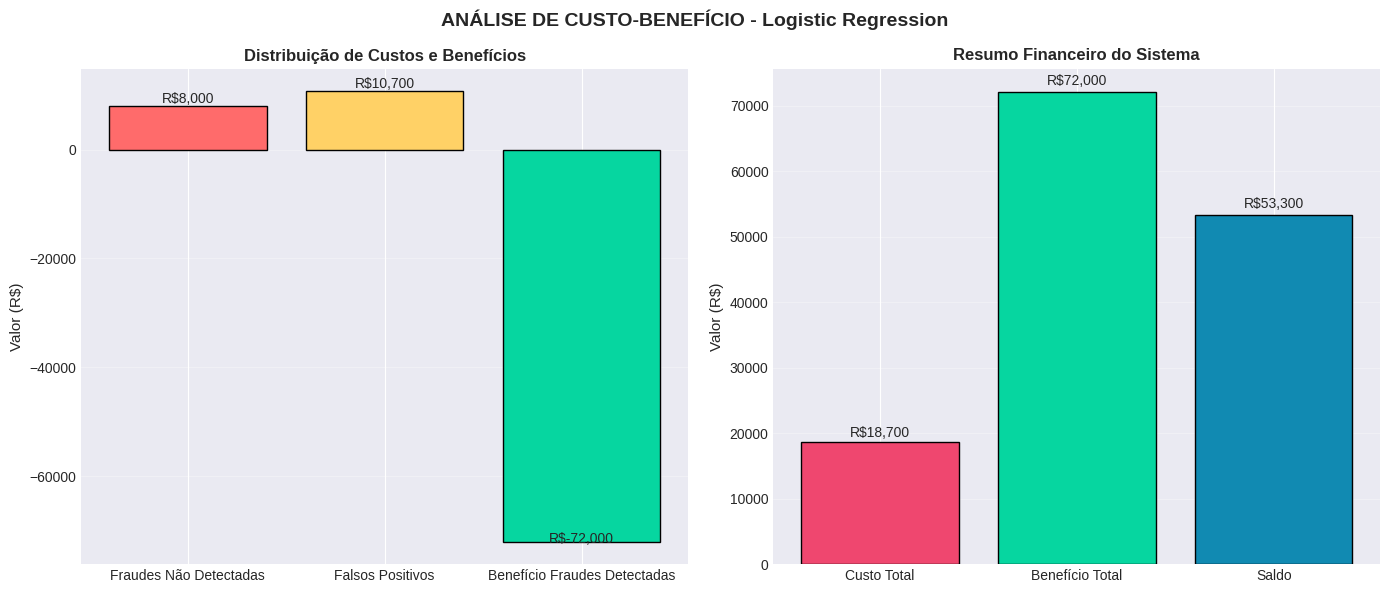

In [72]:
#ANÁLISE DE CUSTO-BENEFÍCIO

print("\n" + "="*80)
print("9. ANÁLISE DE CUSTO-BENEFÍCIO")
print("="*80)

if results and best_model_name:
    print("\n ANÁLISE FINANCEIRA DO MODELO")
    print("-" * 50)

    #Custos hipotéticos (ajuste conforme seu caso real)
    CUSTO_FRAUDE_NAO_DETECTADA = 1000  # R$ por fraude que passa
    CUSTO_FALSO_POSITIVO = 10          # R$ para investigar transação legítima
    RECUPERACAO_FRAUDE = 800           # R$ recuperados ao detectar fraude

    #Obter matriz de confusão do melhor modelo com threshold ótimo
    y_pred_optimal = (results[best_model_name]['y_pred_proba'] >= optimal_threshold_f1).astype(int)
    optimal_cm = confusion_matrix(y_test, y_pred_optimal)
    tn, fp, fn, tp = optimal_cm.ravel()

    #Calcular custos e benefícios
    custo_fraudes_nao_detectadas = fn * CUSTO_FRAUDE_NAO_DETECTADA
    custo_falsos_positivos = fp * CUSTO_FALSO_POSITIVO
    beneficio_fraudes_detectadas = tp * RECUPERACAO_FRAUDE

    custo_total = custo_fraudes_nao_detectadas + custo_falsos_positivos
    beneficio_total = beneficio_fraudes_detectadas
    saldo = beneficio_total - custo_total
    roi = (saldo / custo_total) * 100 if custo_total > 0 else float('inf')

    print(f"\n ESTATÍSTICAS DO MODELO ({best_model_name}):")
    print(f"   Verdadeiros Positivos: {tp:,} fraudes detectadas")
    print(f"   Falsos Positivos: {fp:,} investigações desnecessárias")
    print(f"   Falsos Negativos: {fn:,} fraudes não detectadas")
    print(f"   Verdadeiros Negativos: {tn:,} transações corretamente classificadas")

    print(f"\n CUSTOS E BENEFÍCIOS:")
    print(f"   Custo com fraudes não detectadas: R${custo_fraudes_nao_detectadas:,.2f}")
    print(f"   Custo com falsos positivos: R${custo_falsos_positivos:,.2f}")
    print(f"   Benefício com fraudes detectadas: R${beneficio_fraudes_detectadas:,.2f}")
    print(f"   Custo Total: R${custo_total:,.2f}")
    print(f"   Benefício Total: R${beneficio_total:,.2f}")
    print(f"   Saldo (Benefício - Custo): R${saldo:,.2f}")
    print(f"   ROI: {roi:.1f}%")

    print(f"\n EFICIÊNCIA DO SISTEMA:")
    print(f"   Fraudes prevenidas: {tp/(tp+fn)*100:.1f}%")
    print(f"   Custo por fraude prevenida: R${custo_total/tp if tp > 0 else 0:,.2f}")
    print(f"   Economia por transação: R${saldo/len(y_test):.2f}")

    #Visualização dos custos
    fig, ax = plt.subplots(1, 2, figsize=(14, 6))

    #Gráfico 1: Distribuição de custos
    cost_categories = ['Fraudes Não Detectadas', 'Falsos Positivos', 'Benefício Fraudes Detectadas']
    cost_values = [custo_fraudes_nao_detectadas, custo_falsos_positivos, -beneficio_fraudes_detectadas]
    colors = ['#FF6B6B', '#FFD166', '#06D6A0']

    bars1 = ax[0].bar(cost_categories, cost_values, color=colors, edgecolor='black')
    ax[0].set_ylabel('Valor (R$)', fontsize=11)
    ax[0].set_title('Distribuição de Custos e Benefícios', fontsize=12, fontweight='bold')
    ax[0].grid(True, alpha=0.3, axis='y')

      # Adicionar valores
    for bar, value in zip(bars1, cost_values):
        height = bar.get_height()
        ax[0].text(bar.get_x() + bar.get_width()/2., height + (height*0.01),
                  f'R${value:,.0f}', ha='center', va='bottom', fontsize=10)

     #Gráfico 2: Resumo financeiro


    summary_labels = ['Custo Total', 'Benefício Total', 'Saldo']
    summary_values = [custo_total, beneficio_total, saldo]
    summary_colors = ['#EF476F', '#06D6A0', '#118AB2']

    bars2 = ax[1].bar(summary_labels, summary_values, color=summary_colors, edgecolor='black')
    ax[1].set_ylabel('Valor (R$)', fontsize=11)
    ax[1].set_title('Resumo Financeiro do Sistema', fontsize=12, fontweight='bold')
    ax[1].grid(True, alpha=0.3, axis='y')

    #Adicionar valores
    for bar, value in zip(bars2, summary_values):
        height = bar.get_height()
        ax[1].text(bar.get_x() + bar.get_width()/2., height + (height*0.01),
                  f'R${value:,.0f}', ha='center', va='bottom', fontsize=10)

    plt.suptitle(f'ANÁLISE DE CUSTO-BENEFÍCIO - {best_model_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

In [70]:
#DEPLOY E SALVAMENTO DO MODELO

print("\n" + "="*80)
print("10. DEPLOY E SALVAMENTO DO MODELO")
print("="*80)

if best_model_name in best_models:
    print(f"\n SALVANDO O MELHOR MODELO: {best_model_name}")

    #Criar dicionário com todos os componentes
    model_package = {
        'model': best_models[best_model_name],
        'scaler': scaler, # This is the original scaler fit on X (29 features)
        'important_features_for_engineering': important_features, # Added for feature engineering
        'final_feature_names': list(X_train_final.columns), # Renamed for clarity
        'optimal_threshold': optimal_threshold_f1 if 'optimal_threshold_f1' in locals() else 0.5,
        'metadata': {
            'best_model_name': best_model_name,
            'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
            'dataset_shape': df.shape,
            'performance_metrics': {
                'auc': results[best_model_name]['auc'],
                'f1': results[best_model_name]['f1'],
                'precision': results[best_model_name]['precision'],
                'recall': results[best_model_name]['recall']
            }
        }
    }


10. DEPLOY E SALVAMENTO DO MODELO

 SALVANDO O MELHOR MODELO: Logistic Regression


In [71]:
    #Salvar o pacote completo
    model_filename = f'best_fraud_detection_model_{best_model_name.replace(" ", "_")}.pkl'
    joblib.dump(model_package, model_filename)
    print(f" Modelo salvo como: {model_filename}")

    #Salvar resultados em JSON para documentação
    results_summary = {
        'best_model': best_model_name,
        'best_params': results[best_model_name]['best_params'],
        'metrics': {
            'auc_roc': float(results[best_model_name]['auc']),
            'f1_score': float(results[best_model_name]['f1']),
            'precision': float(results[best_model_name]['precision']),
            'recall': float(results[best_model_name]['recall']),
            'accuracy': float(results[best_model_name]['accuracy'])
        },
        'optimal_threshold': float(optimal_threshold_f1 if 'optimal_threshold_f1' in locals() else 0.5),
        'confusion_matrix': results[best_model_name]['confusion_matrix'].tolist(),
        'feature_importance': {}
    }

    #Adicionar importância das features se disponível
    if best_model_name in ensemble_models:
        try:
            model = best_models[best_model_name]
            if hasattr(model, 'feature_importances_'):
                importances = model.feature_importances_
                feature_names = X_train_final.columns # Use X_train_final.columns for feature names

                for feature, importance in zip(feature_names, importances):
                    results_summary['feature_importance'][feature] = float(importance)
        except:
            pass

    with open('model_results_summary.json', 'w') as f:
        json.dump(results_summary, f, indent=4)

    print(" Resultados salvos em: model_results_summary.json")

    #Função de previsão para produção
    print("\n CRIANDO FUNÇÃO PARA PREDIÇÃO EM PRODUÇÃO")
    print("-" * 50)

    # Re-define criar_features_inteligentes function as it was defined in a previous cell
    def criar_features_inteligentes_for_prediction(X_df, important_features):
        """
        Cria features adicionais baseadas em interações e transformações para um único DataFrame.
        """
        X_local = X_df.copy()

        #Exemplo 1: Interações entre variáveis importantes
        for i, feat1 in enumerate(important_features):
            for feat2 in important_features[i+1:]:
                if feat1 in X_local.columns and feat2 in X_local.columns:
                    X_local[f'{feat1}_x_{feat2}'] = X_local[feat1] * X_local[feat2]

        #Exemplo 2: Quadrados de variáveis (se fizer sentido)
        for feature in ['V14', 'V17', 'Amount']:
            if feature in X_local.columns:
                X_local[f'{feature}_sq'] = X_local[feature]**2

        #Exemplo 3: Valor absoluto (útil para variáveis PCA com significado de "magnitude")
        for feature in ['V3', 'V10', 'V12']:
            if feature in X_local.columns:
                X_local[f'{feature}_abs'] = X_local[feature].abs()
        return X_local

    #Exemplo de função de predição
    def predict_fraud(transaction_data, model_path=model_filename, threshold=None):
        """
        Função para prever se uma transação é fraudulenta.

        Args:
            transaction_data: DataFrame ou dicionário com os dados da transação,
                              contendo as features originais (V1-V28, Amount).
            model_path: Caminho para o modelo salvo
            threshold: Threshold para classificação (usa o ótimo se None)

        Returns:
            dict: Resultado da predição com probabilidade e classificação
        """
        #Carregar modelo
        model_package = joblib.load(model_path)
        model = model_package['model']
        scaler = model_package['scaler']
        important_features = model_package['important_features_for_engineering']
        final_feature_names = model_package['final_feature_names']
        optimal_threshold = model_package.get('optimal_threshold', 0.5)

        #Usar threshold fornecido ou o ótimo
        if threshold is None:
            threshold = optimal_threshold

        #Preparar dados
        if isinstance(transaction_data, dict):
            transaction_df = pd.DataFrame([transaction_data])
        else:
            transaction_df = transaction_data.copy()

        # Ensure all original features are present before scaling
        # The original X had 29 features: V1-V28, Amount
        original_features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
        for feature in original_features:
            if feature not in transaction_df.columns:
                transaction_df[feature] = 0.0 # Default to 0.0 for missing numerical features

        # Reordenar colunas para corresponder à ordem do scaler original
        transaction_df = transaction_df[original_features]

        # 1. Escalonar as features originais
        transaction_scaled_array = scaler.transform(transaction_df)
        transaction_scaled_df = pd.DataFrame(transaction_scaled_array, columns=original_features, index=transaction_df.index)

        # 2. Aplicar Engenharia de Features
        transaction_engineered_df = criar_features_inteligentes_for_prediction(transaction_scaled_df, important_features)

        # 3. Selecionar as features finais
        # Garantir que todas as features esperadas pelo modelo existam, preenchendo com 0 si necessário
        for feature in final_feature_names:
            if feature not in transaction_engineered_df.columns:
                transaction_engineered_df[feature] = 0.0 # Fill new engineered features if they don't exist

        transaction_final = transaction_engineered_df[final_feature_names]

        #Fazer predição
        probability = model.predict_proba(transaction_final)[0, 1]
        is_fraud = probability >= threshold

        return {
            'probability': float(probability),
            'is_fraud': bool(is_fraud),
            'threshold': float(threshold),
            'features_used': list(final_feature_names), # Ensure it's a list
            'model_name': model_package['metadata']['best_model_name']
        }

    print(" Função de predição criada!")

    #Testar a função com exemplo
    print("\n TESTANDO A FUNÇÃO DE PREDIÇÃO COM EXEMPLO")
    print("-" * 50)

    # This section was previously in CVhn02Aydac0 and T3Z3sF8kCXap
    # The example transaction should have the original features before any preprocessing
    # For demonstration, let's pick a random fraudulent transaction from df
    fraud_example_row = df[df['Class'] == 1].drop(columns=['Class', 'Time', 'Hour', 'Hour_of_day']).sample(1, random_state=42).iloc[0]
    example_transaction_raw = fraud_example_row.to_dict()

    #Fazer predição
    try:
        prediction = predict_fraud(example_transaction_raw)
        print(f" EXEMPLO DE TRANSAÇÃO (raw input):")
        for key, value in list(example_transaction_raw.items())[:5]:  # Mostrar apenas 5 features
            print(f"   {key}: {value:.4f}")
        print(f"\n RESULTADO DA PREDIÇÃO:")
        print(f"   Probabilidade de fraude: {prediction['probability']:.4f}")
        print(f"   Classificação (threshold={prediction['threshold']:.2f}): {'FRAUDE' if prediction['is_fraud'] else 'NORMAL'}")
        print(f"   Modelo utilizado: {prediction['model_name']}")
    except Exception as e:
        print(f" Erro ao testar predição: {str(e)}")

 Modelo salvo como: best_fraud_detection_model_Logistic_Regression.pkl
 Resultados salvos em: model_results_summary.json

 CRIANDO FUNÇÃO PARA PREDIÇÃO EM PRODUÇÃO
--------------------------------------------------
 Função de predição criada!

 TESTANDO A FUNÇÃO DE PREDIÇÃO COM EXEMPLO
--------------------------------------------------
 EXEMPLO DE TRANSAÇÃO (raw input):
   V1: -29.2003
   V2: 16.1557
   V3: -30.0137
   V4: 6.4767
   V5: -21.2258

 RESULTADO DA PREDIÇÃO:
   Probabilidade de fraude: 1.0000
   Classificação (threshold=0.85): FRAUDE
   Modelo utilizado: Logistic Regression


In [47]:
#Testar a função com exemplo
print("\n TESTANDO A FUNÇÃO DE PREDIÇÃO COM EXEMPLO")
print("-" * 50)

#Criar exemplo de transação
example_transaction = {}
for feature in X_train_final.columns[:10]:  # Apenas algumas features
    example_transaction[feature] = X_test_final.iloc[0][feature]


 TESTANDO A FUNÇÃO DE PREDIÇÃO COM EXEMPLO
--------------------------------------------------


In [48]:
    #Fazer predição
    try:
        prediction = predict_fraud(example_transaction)
        print(f" EXEMPLO DE TRANSAÇÃO:")
        for key, value in list(example_transaction.items())[:5]:  # Mostrar apenas 5 features
            print(f"   {key}: {value:.4f}")
        print(f"\n RESULTADO DA PREDIÇÃO:")
        print(f"   Probabilidade de fraude: {prediction['probability']:.4f}")
        print(f"   Classificação (threshold={prediction['threshold']:.2f}): {'FRAUDE' if prediction['is_fraud'] else 'NORMAL'}")
        print(f"   Modelo utilizado: {prediction['model_name']}")
    except Exception as e:
        print(f" Erro ao testar predição: {str(e)}")

 EXEMPLO DE TRANSAÇÃO:
   V4: -0.8219
   V10: 0.7517
   V12: -0.3614
   V14: 0.2349
   V14_x_V17: 0.3736

 RESULTADO DA PREDIÇÃO:
   Probabilidade de fraude: 0.0242
   Classificação (threshold=0.85): NORMAL
   Modelo utilizado: Logistic Regression


In [73]:
#RELATÓRIO FINAL

print("\n" + "="*80)
print("11. RELATÓRIO FINAL DO PROJETO")
print("="*80)

print("\n RESUMO EXECUTIVO")
print("-" * 50)

if best_model_name in results:
    best_result = results[best_model_name]

    print(f"\n MODELO SELECIONADO: {best_model_name}")
    print(f"   AUC-ROC: {best_result['auc']:.4f}")
    print(f"   F1-Score: {best_result['f1']:.4f}")
    print(f"   Precisão: {best_result['precision']:.4f}")
    print(f"   Recall: {best_result['recall']:.4f}")

    print(f"\n THRESHOLD ÓTIMO: {optimal_threshold_f1 if 'optimal_threshold_f1' in locals() else 0.5:.3f}")

    print(f"\n DESEMPENHO OPERACIONAL:")
    print(f"   Taxa de Detecção (Recall): {best_result['recall']*100:.1f}%")
    print(f"   Precisão nas Alertas: {best_result['precision']*100:.1f}%")
    print(f"   Falsos Positivos: {best_result['false_positives']/len(y_test)*100:.4f}%")

    print(f"\n IMPACTO FINANCEIRO ESTIMADO:")
    if 'saldo' in locals():
        print(f"   Saldo Líquido: R${saldo:,.2f}")
        print(f"   ROI: {roi:.1f}%")
        print(f"   Economia por transação: R${saldo/len(y_test):.2f}")

print("\n PROJETO CONCLUÍDO COM SUCESSO!")
print("\n" + "="*80)
print("PRÓXIMOS PASSOS RECOMENDADOS:")
print("="*80)
print("1.  Validação em dados recentes (teste A/B)")
print("2.  Implementação em ambiente de produção")
print("3.  Monitoramento contínuo do modelo (concept drift)")
print("4.  Retreinamento periódico com novos dados")
print("5.  Ajuste fino com feedback do negócio")
print("6.  Integração com sistemas de alerta em tempo real")


11. RELATÓRIO FINAL DO PROJETO

 RESUMO EXECUTIVO
--------------------------------------------------

 MODELO SELECIONADO: Logistic Regression
   AUC-ROC: 0.9739
   F1-Score: 0.0380
   Precisão: 0.0194
   Recall: 0.9286

 THRESHOLD ÓTIMO: 0.850

 DESEMPENHO OPERACIONAL:
   Taxa de Detecção (Recall): 92.9%
   Precisão nas Alertas: 1.9%
   Falsos Positivos: 8.0826%

 IMPACTO FINANCEIRO ESTIMADO:
   Saldo Líquido: R$53,300.00
   ROI: 285.0%
   Economia por transação: R$0.94

 PROJETO CONCLUÍDO COM SUCESSO!

PRÓXIMOS PASSOS RECOMENDADOS:
1.  Validação em dados recentes (teste A/B)
2.  Implementação em ambiente de produção
3.  Monitoramento contínuo do modelo (concept drift)
4.  Retreinamento periódico com novos dados
5.  Ajuste fino com feedback do negócio
6.  Integração com sistemas de alerta em tempo real
